#0. Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = ###
results_path = ###

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd 
import re
import json
from tqdm import tqdm

from nltk import download
download('stopwords')
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#1. Load dataset

In [ ]:
# load json file

data_file = data_path+'/arxiv-metadata-oai-snapshot.json'

""" loading articles not overloading memory"""

def get_metadata():
    with open(data_file, 'r') as f:
        for line in f:
            yield line

# we will consider specific categories for training: https://arxiv.org/category_taxonomy

# categories related to computer science
paper_categories = ["cs.AI", # Artificial Intelligence
                    "cs.CV", # Computer Vision and Pattern Recognition
                    "cs.LG", # Machine Learning
                    "cs.HC", # Human-Computer Interaction
                    "cs.CL", # Computation and Language
                    "cs.CY", # Computers and Society
                    "cs.NE", # Neural and Evolutionary Computing
                    "cs.IR", # Information Retrieval
                    "cs.SI", # Social and Information Networks
                    "cs.DS", # Data Structure and Algorithms
                    "cs.LO", # Logic in Computer Science
                    "cs.DC", # Distributed, Parallel, and Cluster Computing
                    "cs.CR", # Cryptography and Security
                    "cs.GL", # General Literature
                    "cs.MA", # Multiagent Systems
                    "cs.PL", # Programming Languages
                    "cs.RO", # Robotics
                    "cs.SC", # Symbolic Computation
                    "cs.SD", # Sound
                    "cs.SE", # Software Engineering
                    "cs.ET"] # Emerging Technologies



list_categories=[]

#build dataset filtering articles by categories in the list
def build_dataset(categories=paper_categories):
    titles = []
    abstracts = []
    metadata = get_metadata()
    for paper in tqdm(metadata):
        paper_dict = json.loads(paper)
        category = paper_dict.get('categories')
        if category not in list_categories:
          list_categories.append(category)
        if category in categories:
            try:
                titles.append(paper_dict.get('title'))
                abstracts.append(paper_dict.get('abstract').replace("\n",""))
            except:
                pass 

    papers = pd.DataFrame({'title': titles,'abstract': abstracts})
    papers = papers.dropna()
    papers["title"] = papers["title"].apply(lambda x: re.sub('\s+',' ', x))
    papers["abstract"] = papers["abstract"].apply(lambda x: re.sub('\s+',' ', x))

    del titles, abstracts
    return papers

In [ ]:
papers = build_dataset()

1893925it [04:56, 6391.16it/s]


In [ ]:
papers

,title,abstract
0,On-line Viterbi Algorithm and Its Relationship...,"In this paper, we introduce the on-line Viter..."
1,Refuting the Pseudo Attack on the REESSE1+ Cry...,We illustrate through example 1 and 2 that th...
2,P-adic arithmetic coding,A new incremental algorithm for data compress...
3,Lessons Learned from the deployment of a high-...,This paper presents an experimental study and...
4,Text Line Segmentation of Historical Documents...,There is a huge amount of historical document...
...,...,...
100942,Fast Hierarchical Clustering and Other Applica...,We develop data structures for dynamic closes...
100943,Mixed-Level Knowledge Representation and Varia...,A system is described that uses a mixed-level...
100944,Computation in an algebra of test selection cr...,One of the key concepts in testing is that of...
100945,Quantum Bit Commitment Expansion,The paper was retracted.


In [ ]:
papers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100947 entries, 0 to 100946
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   title     100947 non-null  object
 1   abstract  100947 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [ ]:
# Check for any nulls values
papers.isnull().sum()

title       0
abstract    0
dtype: int64

#2. Preprocessing

In [ ]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions =          {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have", "i've": "i have"}



In [ ]:
def clean_text(text, remove_stopwords = True):
    
    #lower case
    text = text.lower()

    #remove contractions
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)

    #remove unicode characters
    text = text.encode('ascii', 'ignore').decode()

    #remove stop words
    if remove_stopwords:
      stop_words = set(stopwords.words("english"))
      text = " ".join([word for word in text.split()if word not in stop_words])

    #remove punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)

    #remove numbers
    text = re.sub(r'\w*\d+\w*', '', text)

    #replace the over spaces
    text = re.sub('\s{2,}', " ", text)



    return text


In [ ]:
cleaned_titles = []
cleaned_abstracts = []

for titles in papers['title']:
    cleaned_titles.append(clean_text(titles, remove_stopwords=False))
print("Titles are complete.")

for abstract in papers['abstract']:
    cleaned_abstracts.append(clean_text(abstract))
print("Abstracts are complete.")

Titles are complete.
Abstracts are complete.


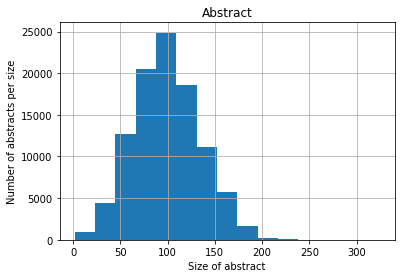

In [ ]:
# distribution of words

abstract_word_count = []
title_word_count = []

for i in cleaned_abstracts:
    abstract_word_count.append(len(i.split()))
for i in cleaned_titles:
    title_word_count.append(len(i.split()))

abstract_df = pd.DataFrame({'Abstract': abstract_word_count})
abstract_df.hist(bins=15)
plt.xlabel('Size of abstract')
plt.ylabel('Number of abstracts per size')

plt.show()

Text(0, 0.5, 'Number of titles per size')

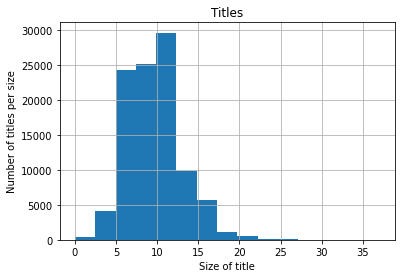

In [ ]:
titles_df = pd.DataFrame({'Titles': title_word_count})
titles_df.hist(bins=15)
plt.xlabel('Size of title')
plt.ylabel('Number of titles per size')

By limitting abstract length to 180, 98% of papers will be covered.

In [ ]:
counter = 0
for i in cleaned_abstracts:
    if(len(i.split())<=180):
        counter += 1
print(counter/len(cleaned_abstracts))

0.9892715979672502


By limitting title length to 20, 99% of papers will be covered.

In [ ]:
counter = 0
for i in cleaned_titles:
    if(len(i.split())<=20):
        counter += 1
print(counter/len(cleaned_titles))

0.9949676562948874


In [ ]:
#create dataframe using the length limitations chosen above

max_headlines_len = 20
max_text_len = 180

cleaned_abstracts = np.array(cleaned_abstracts)
cleaned_titles = np.array(cleaned_titles)

short_text=[]
short_headlines=[]

for i in range(len(cleaned_abstracts)):
    
    if(len(cleaned_titles[i].split())<=max_headlines_len and len(cleaned_abstracts[i].split())<=max_text_len):
        short_text.append(cleaned_abstracts[i])
        short_headlines.append(cleaned_titles[i])

## adding 'sostok': start of sentence, and 'eostok': end  of sentence as tokens in headlines
df=pd.DataFrame({'text':short_text,'headlines':short_headlines})
df['headlines'] = df['headlines'].apply(lambda x : 'sostok '+ x + ' eostok')


In [ ]:
df

,text,headlines
0,paper introduce on line viterbi algorithm deco...,sostok on line viterbi algorithm and its relat...
1,illustrate example condition theorem dissatisf...,sostok refuting the pseudo attack on the crypt...
2,new incremental algorithm data compression pre...,sostok p adic arithmetic coding eostok
3,paper presents experimental study lessons lear...,sostok lessons learned from the deployment of ...
4,huge amount historical documents libraries var...,sostok text line segmentation of historical do...
...,...,...
99365,develop data structures dynamic closest pair p...,sostok fast hierarchical clustering and other ...
99366,system described uses mixed level knowledge re...,sostok mixed level knowledge representation an...
99367,one key concepts testing adequate test sets te...,sostok computation in an algebra of test selec...
99368,paper retracted,sostok quantum bit commitment expansion eostok


In [ ]:
#reducing dataframe size to equalize the size of the other dataframe used for the training of the model
df = df.sample(n = 98378 )

#3. Write to file preprocessed data

In [ ]:
from sklearn.model_selection import train_test_split
#train and test split
x_tr, x_test, y_tr, y_test=train_test_split(np.array(df['text']), np.array(df['headlines']), test_size=0.15, random_state=0, shuffle=True)

#train and val split
x_tr, x_val, y_tr, y_val=train_test_split(x_tr, y_tr , test_size=0.15, random_state=0, shuffle=True)

In [ ]:
training_arxiv = pd.DataFrame({'text':x_tr, 'headlines':y_tr})
test_arxiv = pd.DataFrame({'text':x_test, 'headlines':y_test})
validation_arxiv = pd.DataFrame({'text':x_val, 'headlines': y_val})

In [ ]:
training_arxiv.to_csv(results_path+'training_arxiv_preprocessed.csv',index=False)
test_arxiv.to_csv(results_path+'test_arxiv_preprocessed.csv',index=False)
validation_arxiv.to_csv(results_path+'validation_arxiv_preprocessed.csv',index=False)